In [1]:
import time
import torch
import warnings
import numpy as np
import matplotlib.pyplot as plt

from pina import Condition, LabelTensor, Trainer
from pina.solver import PINN
from pina.operator import grad
from pina.equation import Equation, FixedValue
from pina.model import FeedForward
from pina.callback import MetricTracker
from pina.domain import CartesianDomain
from pina.problem import SpatialProblem, TimeDependentProblem

In [2]:
# Definición del problema de advección 2D
class Advection(TimeDependentProblem, SpatialProblem):
    output_variables = ["u"]
    spatial_domain = CartesianDomain({"x": [0, 1], "y": [0, 1]})
    temporal_domain = CartesianDomain({"t": [0, 1]})
    domains = {
        "g1": CartesianDomain({"x": 1, "y": [0, 1], "t": [0, 1]}),
        "g2": CartesianDomain({"x": 0, "y": [0, 1], "t": [0, 1]}),
        "g3": CartesianDomain({"x": [0, 1], "y": 0, "t": [0, 1]}),
        "g4": CartesianDomain({"x": [0, 1], "y": 1, "t": [0, 1]}),
        "initial": CartesianDomain({"x": [0, 1], "y": [0, 1], "t": 0}),
        "D": CartesianDomain({"x": [0, 1], "y": [0, 1], "t": [0, 1]}),
    }

    def __init__(self):
        super().__init__()
        self.cx = torch.nn.Parameter(torch.rand(1))
        self.cy = torch.nn.Parameter(torch.rand(1))
        #self.amplitud = torch.nn.Parameter(torch.rand(1) * 0.5)
        self.amplitudes = torch.nn.ParameterList([torch.nn.Parameter(torch.rand(1)) for _ in range(2)])

    # Definición del PDE (advección)
    def advection_eq(self, input_, output_):

        # Ecuación de advección: u_t + c_x * u_x + c_y * u_y= 0
        
        u_t = grad(output_, input_, components=["u"], d=["t"])
        u_x = grad(output_, input_, components=["u"], d=["x"])
        u_y = grad(output_, input_, components=["u"], d=["y"])
        return u_t + self.cx * u_x + self.cy * u_y

    # Condición inicial
    def initial_condition(self, input_, output_):

        # Condición inicial u(x, 0) = sum_k a_k * sin(2*pi*k*x) * sin(2*pi*k*y)
        
        x = input_.extract(["x"])
        y = input_.extract(["y"])
        
        u_0 = torch.zeros_like(x)
        for k in range(1, 3):
            u_0 += self.amplitudes[k - 1] * torch.sin(2 * torch.pi * k * x) * torch.sin(2 * torch.pi * k * y)
        return output_.extract(["u"]) - u_0

    # Solución analítica exacta
    def solution(self, pts):
        x = pts.extract(["x"])
        y = pts.extract(["y"])
        t = pts.extract(["t"])
        
        f = torch.zeros_like(x)
        for k in range(1, 3):
            shifted_x = (x - self.cx * t) % 1.0
            shifted_y = (y - self.cy * t) % 1.0
            f += self.amplitudes[k - 1] * torch.sin(2 * torch.pi * k * shifted_x) * torch.sin(2 * torch.pi * k * shifted_y)        
        return LabelTensor(f, self.output_variables)

    # Definimos "conditions" como propiedad
    @property
    def conditions(self):
        return {
            "g1": Condition(domain="g1", equation=FixedValue(0.0)),
            "g2": Condition(domain="g2", equation=FixedValue(0.0)),
            "g3": Condition(domain="g3", equation=FixedValue(0.0)),
            "g4": Condition(domain="g4", equation=FixedValue(0.0)),
            "initial": Condition(domain="initial", equation=Equation(self.initial_condition)),
            "D": Condition(domain="D", equation=Equation(self.advection_eq)),
        }

In [3]:
class HardMLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim, amplitudes):
        super().__init__()
        self.amplitudes = amplitudes

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, output_dim),
        )

    def u0(self, x, y):
        
        # Condición inicial u0(x, y), igual a la de Adv.initial_condition
        
        u0 = torch.zeros_like(x)
        for k in range(1, 3):
            u0 += self.amplitudes[k - 1] * torch.sin(2 * torch.pi * k * x) * torch.sin(2 * torch.pi * k * y)
        return u0

    def forward(self, pts):
        x = pts.extract(["x"])
        y = pts.extract(["y"])
        t = pts.extract(["t"])

        hard = x * (1 - x) * y * (1 - y)

        # calculamos u0(x,y)
        u0 = self.u0(x, y)

        # salida de la red
        nn = self.layers(pts)

        # imponemos la restricción dura
        u_pinn = u0 + t * hard * nn
        return u_pinn

In [4]:
def FDM_upwind(amplitudes, cx, cy, dt, bc='dirichlet'):
    """
    u0: initial condition array shape (ny, nx)
    cx, cy: advection velocities (scalars)
    bc: 'periodic' or 'dirichlet' (zero)
    returns u at final time and history optionally
    """

    Lx = Ly = 1.0
    nx = ny = 100
    cx = cx[0].tolist()
    cy = cy[0].tolist()
    nt = 500
    
    dx = Lx / nx
    dy = Ly / ny
    sigma_x = abs(cx) * dt / dx
    sigma_y = abs(cy) * dt / dy
    if sigma_x + sigma_y > 1.0:
        print("WARNING: CFL condition maybe violated: sigma_x+sigma_y =", sigma_x + sigma_y)

    x = np.linspace(0, 1, nx, endpoint=False)
    y = np.linspace(0, 1, ny, endpoint=False)
    X, Y = np.meshgrid(x, y)

    # condición inicial:
    u0 = np.zeros((nx, ny))
    for k in range(1, 4):
       u0 += amplitudes[k - 1].tolist()[0] * np.sin(2 * np.pi * k * X) * np.sin(2 * np.pi * k * Y)
    
    u = u0.copy()
    for n in range(nt):
        un = u.copy()
        # Upwind x-direction
        if cx >= 0:
            ux = un - np.roll(un, 1, axis=1)   # u_i - u_{i-1}
        else:
            ux = np.roll(un, -1, axis=1) - un  # u_{i+1} - u_i
        # Upwind y-direction
        if cy >= 0:
            uy = un - np.roll(un, 1, axis=0)
        else:
            uy = np.roll(un, -1, axis=0) - un

        # update
        u = un - (np.array(cx * (dt/dx)) * ux) - (np.array(cy * (dt/dy)) * uy)

        if bc == 'dirichlet':
            u[0, :] = 0
            u[-1, :] = 0
            u[:, 0] = 0
            u[:, -1] = 0
    return u

In [5]:
# Definimos el problema
problem = Advection()

# Generamos los datos
problem.discretise_domain(1000, "random", domains="all")

# Definimos el modelo
model = HardMLP(
    input_dim=3,  # x, y, t
    output_dim=1,
    amplitudes=problem.amplitudes
    )

# Definimos la solución
solver = PINN(problem=problem, model=model)

In [6]:
print("Input vars:", problem.input_variables)
print("Output vars:", problem.output_variables)
print("Model input dim:", len(problem.input_variables))
print("Model output dim:", len(problem.output_variables))

Input vars: ['x', 'y', 't']
Output vars: ['u']
Model input dim: 3
Model output dim: 1


In [7]:
# create trainer and train
trainer = Trainer(
    solver=solver,
    max_epochs=151,
    accelerator="cpu",
    enable_model_summary=False,
    train_size=0.7,
    val_size=0.2,
    test_size=0.1,
    callbacks=[MetricTracker(["train_loss", "initial_loss", "D_loss"])],
)
start = time.perf_counter()
trainer.train()
end = time.perf_counter()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
C:\Users\brian\miniconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
C:\Users\brian\miniconda3\Lib\site-packages\pina\trainer.py: UserWarning: Compilation is disabled for Python 3.14+ and for Windows.
C:\Users\brian\miniconda3\Lib\site-packages\pina\s

Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=151` reached.


Entrenamiento duró 12.099 segundos


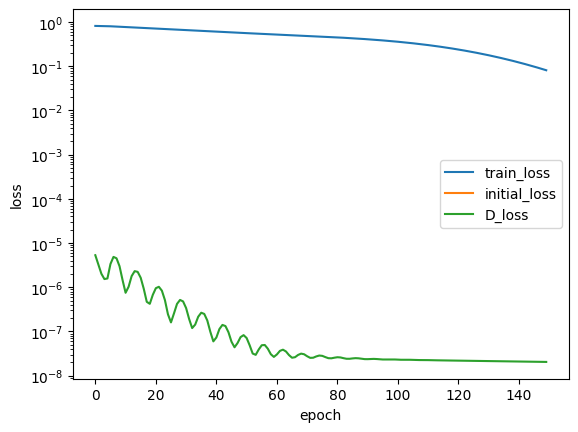

In [8]:
trainer_metrics = trainer.callbacks[0].metrics
for metric, loss in trainer_metrics.items():
    plt.plot(range(len(loss)), loss, label=metric)
# plotting
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.legend()

print(f"Entrenamiento duró {end - start:.3f} segundos")

In [9]:
print(problem.amplitudes[0].tolist(),problem.amplitudes[1].tolist())#,problem.amplitudes[2].tolist())
print(problem.cx[0].tolist(),problem.cy[0].tolist())

[0.6651902198791504] [0.5823043584823608]
0.0589461624622345 0.00477290153503418


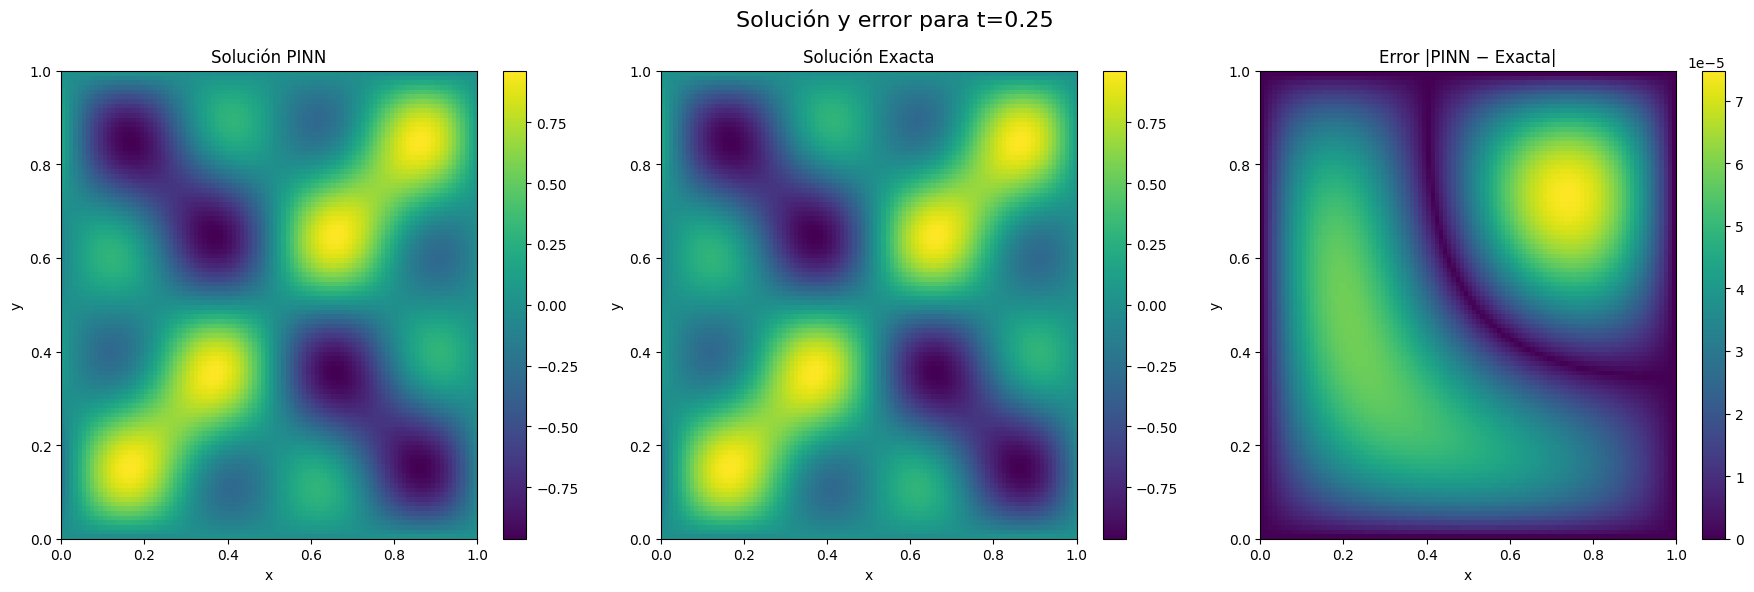

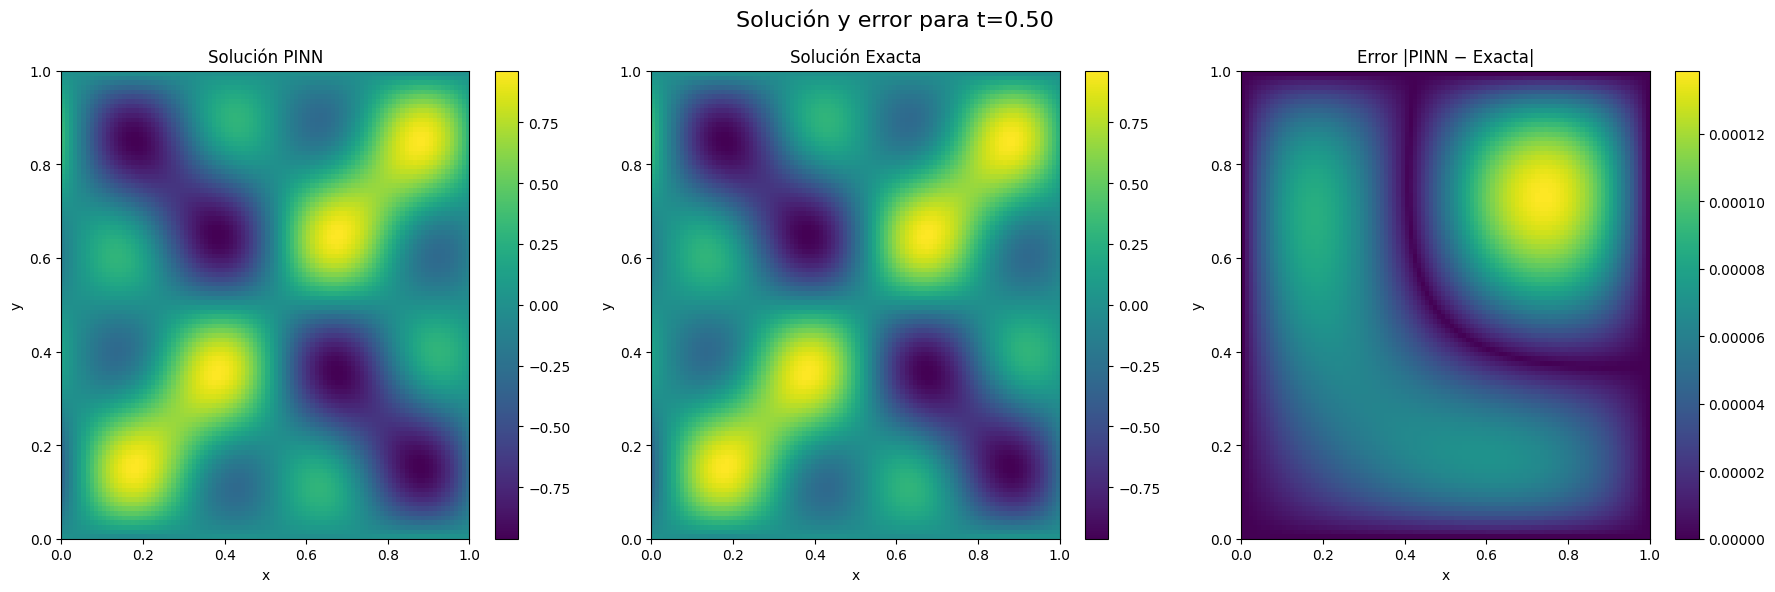

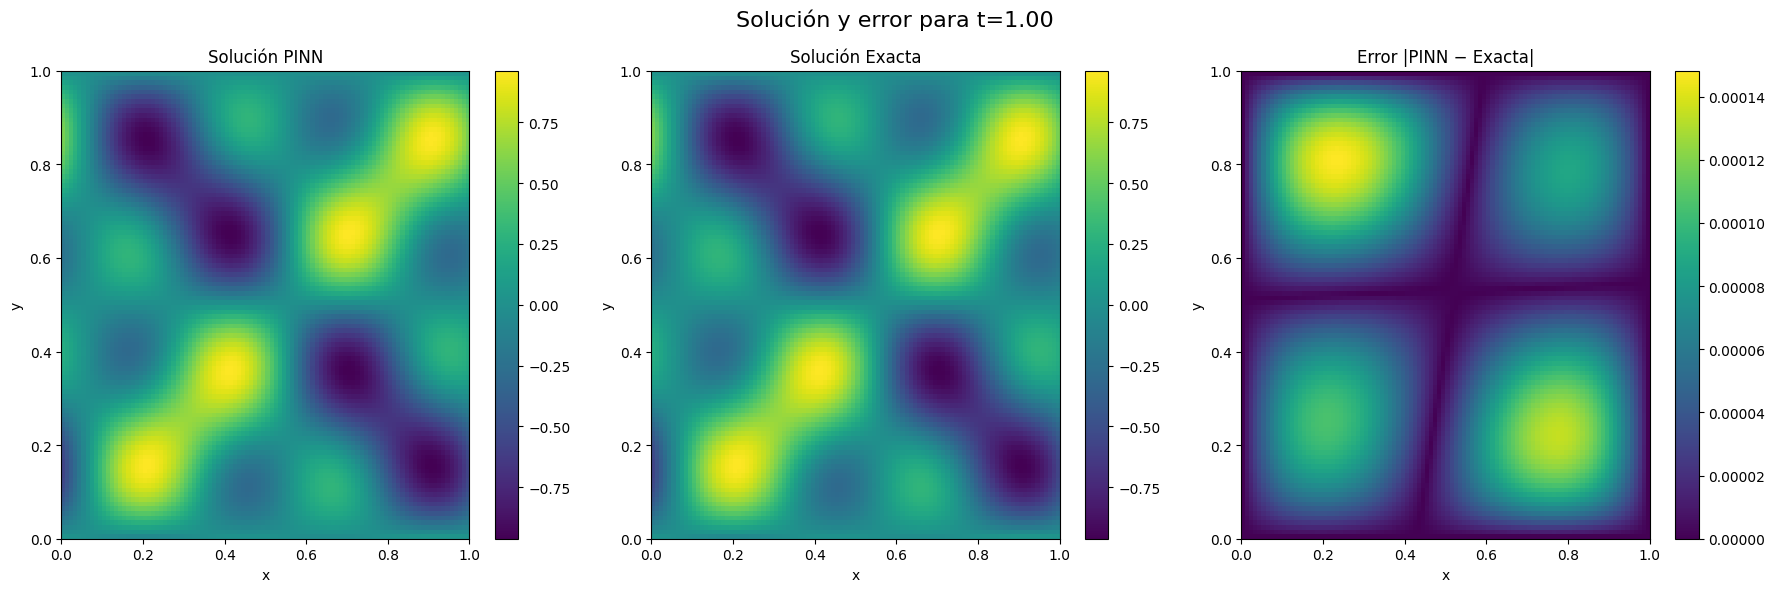

In [11]:
plot_solution(solver, problem, time=0.25)
plot_solution(solver, problem, time=0.5)
plot_solution(solver, problem, time=1)

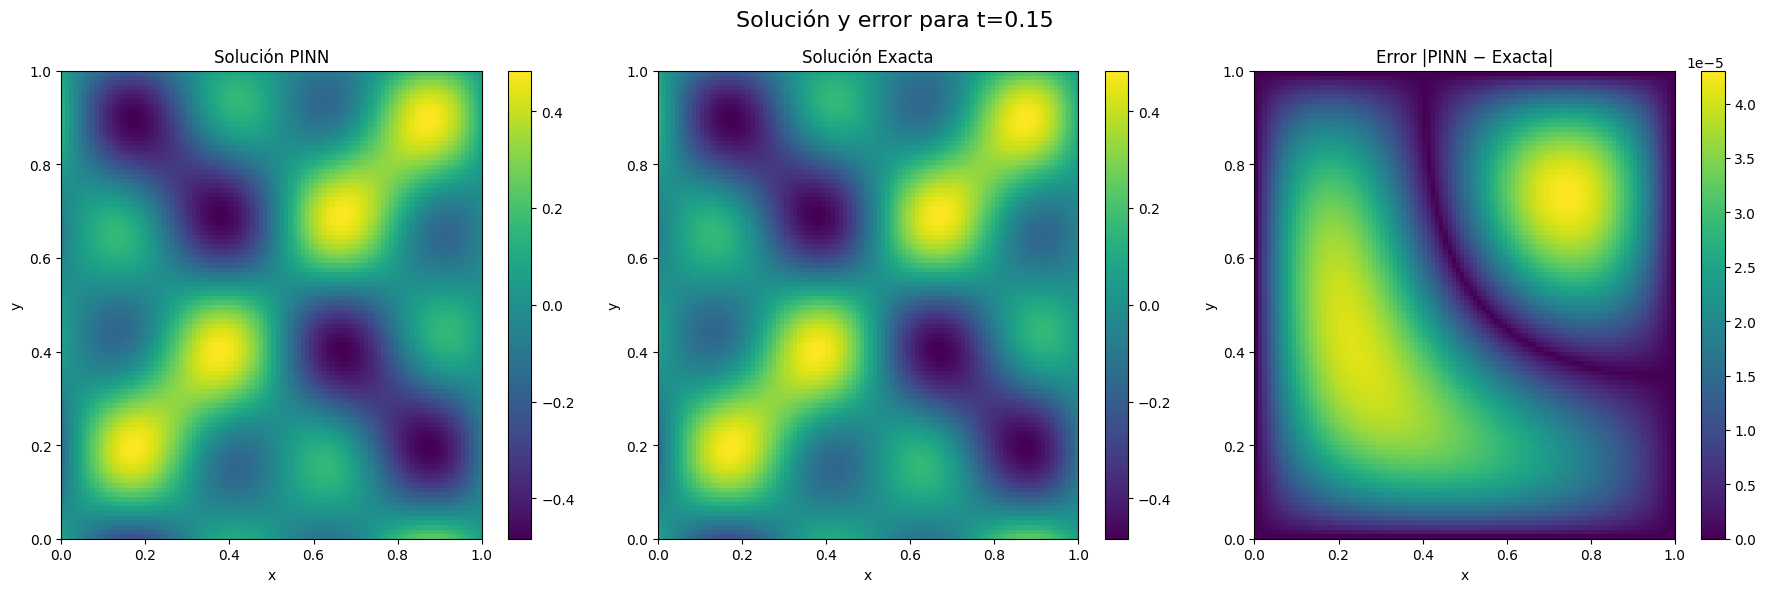

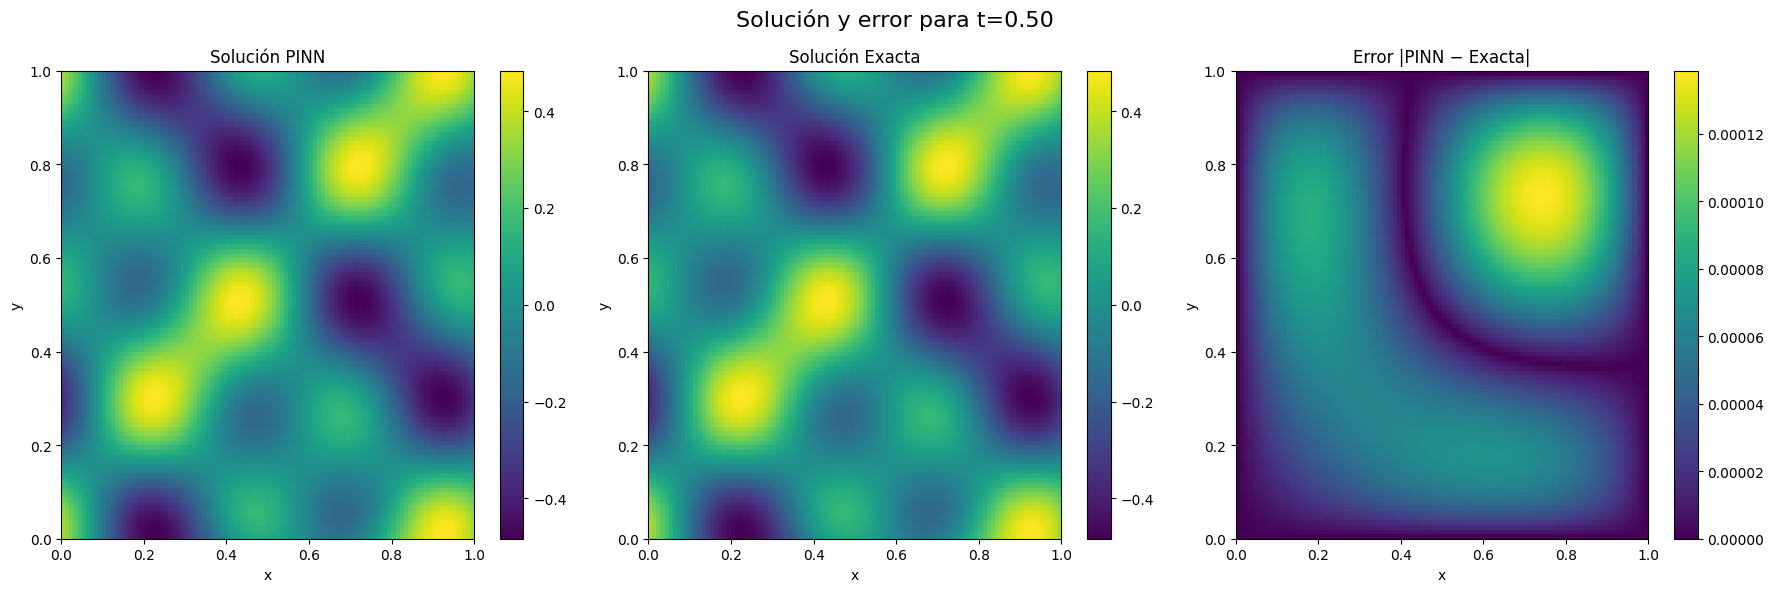

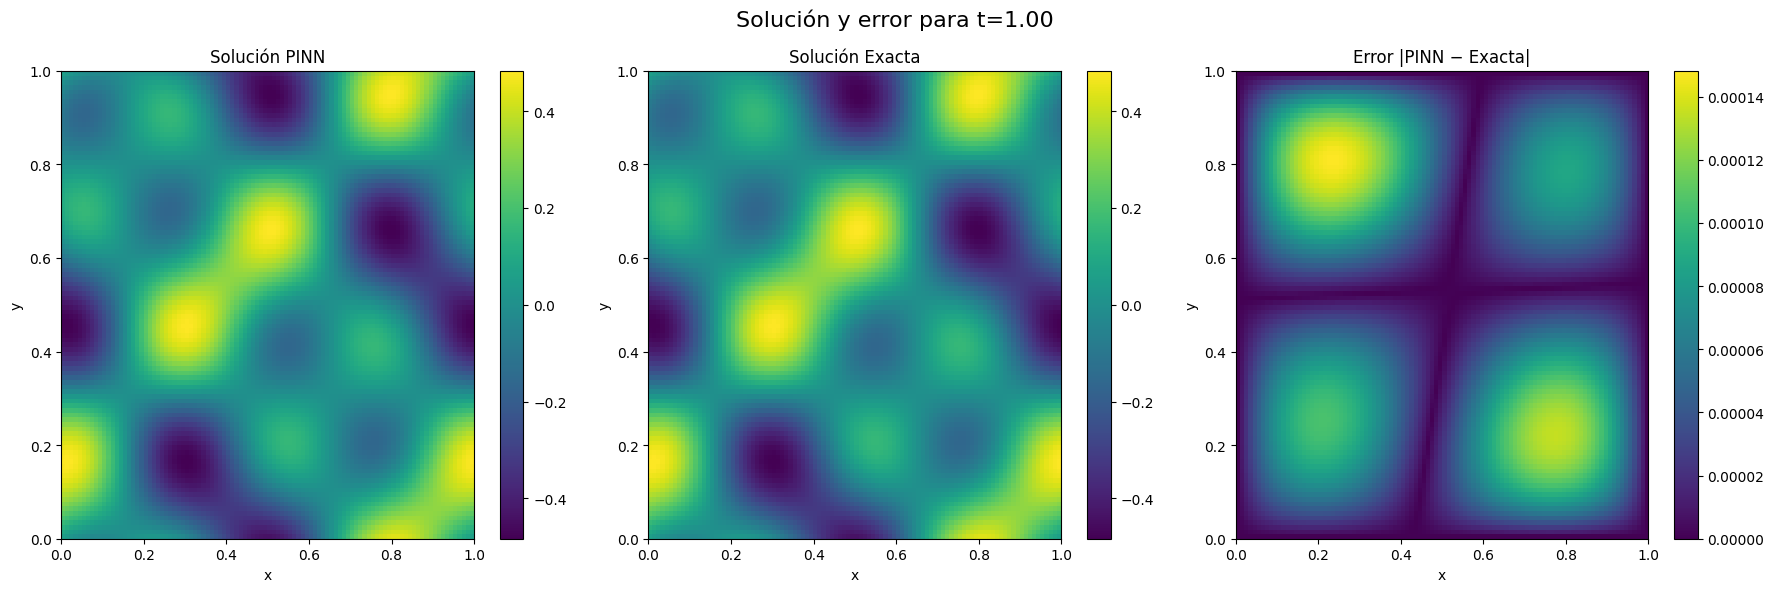

In [12]:
problem_test = Advection()  # Nueva instancia → nuevos valores de amplitudes/fases

# copiar amplitudes y phases del problema nuevo al modelo
solver.model.amplitudes = problem_test.amplitudes
solver.model.cx = problem_test.cx
solver.model.cy = problem_test.cy

plot_solution(solver, problem_test, time=0.15)
plot_solution(solver, problem_test, time=0.5)
plot_solution(solver, problem_test, time=1)

In [13]:
print(problem_test.amplitudes[0].tolist(), problem_test.amplitudes[1].tolist())
print(problem_test.cx.tolist())
print(problem_test.cy.tolist())

[0.32162296772003174] [0.3009556531906128]
[0.1551232933998108]
[0.3082885146141052]
